In [1]:
from src import freesurfer_utils
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import nibabel as nib
from dataclasses import dataclass

In [2]:
subjects_dir  = '/Users/benparker/Desktop/cnl/neurocluster/weiner/DevProso/subjects'
subjects_list = subjects_dir + '/all_subjects_list.txt'
subject_paths = freesurfer_utils.get_subjects_list(subjects_list = subjects_list, subjects_dir = subjects_dir)
subjects = [Path(subject_path).name for subject_path in subject_paths]


In [3]:
mfs = pd.read_csv('/Users/benparker/Desktop/cnl/DevProso/data/mfs.csv')
mfs.head()

,sub,hemi,label,vertices,total_surface_area,total_gray_matter_volume,cortical_thickness_mean,cortical_thickness_std,rectified_mean_curvature,rectified_Gaussian_curvature,...,Famous Face,Old-New,max_path_length,group,Sex,Age,FG1_lgi,FG2_lgi,FG3_lgi,FG4_lgi
0,1,rh,MFS,709,501,1251,2.670,0.627,0.104,0.015,...,NaN,NaN,65.449696,Controls,M,49,0.7,0.9,0.9,2.1
1,1,lh,MFS,1019,738,1578,2.514,0.393,0.108,0.014,...,NaN,NaN,62.765262,Controls,M,49,0.5,0.9,1.7,2.9
2,2,rh,MFS,470,351,706,2.503,0.328,0.117,0.016,...,0.43,0.93,32.592076,DPs,M,61,0.8,1.1,1.5,2.3
3,2,lh,MFS,751,561,1129,2.328,0.332,0.106,0.017,...,0.43,0.93,41.841137,DPs,M,61,0.9,1.0,1.7,2.3
4,3,rh,MFS,274,214,621,2.793,0.520,0.133,0.043,...,NaN,NaN,30.554775,Controls,F,52,0.6,0.6,1.6,1.6


## Gyrification ratio by surface area

In [4]:

def mris_anatomical_stats2DataFrame_row(subject: str, label_name: str, hemi: str, data_dir: str or Path) -> pd.DataFrame:
    """ 
    Takes a subject list and the location of a stats.txt file outputted by mris_anatomical_stats ->> converts it to a dataframe



    """

    assert hemi in ['lh', 'rh'], "hemi must be 'lh' or 'rh'"

    if isinstance(data_dir, str):
        data_dir = Path(data_dir)

    txt_path = data_dir / f"{hemi}.{label_name}.stats.txt"
    assert txt_path.exists(), f'the file {txt_path} does not exist.'

    all_stats_df = pd.DataFrame(columns=['sub', 'hemi', 'label', 'num_vertices', 'surface_area_mm^2', 'gray_matter_volume_mm^3', 'avg_cortical_thickness', 'avg_cortical_thickness_std', 'rectified_mean_curvature', 'rectified_gaussian_curvature', 'folding_index', 'intrinsic_curvature'])

    with open(txt_path, 'r') as fp:
        new_surf = fp.readlines()
    
    row_stats = new_surf[-1]
    row_stats = row_stats.split(' ')
    row_stats = [i for i in row_stats if i != '']
    label_name = row_stats[-1][:-1].split('.')[1]

    num_rows =  [row_stats[0], row_stats[1], row_stats[2], row_stats[3], row_stats[4], row_stats[5], row_stats[6], row_stats[7], row_stats[8]]
    num_rows = [float(i) for i in num_rows]
    all_stats_row = [subject, hemi, label_name, num_rows[0], num_rows[1], num_rows[2], num_rows[3], num_rows[4], num_rows[5], num_rows[6], num_rows[7], num_rows[8]]
    
    all_stats_df.loc[len(all_stats_df)] = all_stats_row

    return all_stats_df


def subject_label_stats2DataFrame(subjects_dir: str or Path, subject_list: list, label_name: str or list, hemi: str or list, data_dir_from_subject_fs_dir:str = 'label') -> pd.DataFrame:
    """ 
    Takes a subject list, label list, and the location of a stats.txt file outputted by mris_anatomical_stats ->> converts it to a dataframe

    INPUT:
    subjects_dir: str or Path - FreeSurfer subject directory
    subject_list: list - list of subjects to be included in the dataframe
    label_name: str or list - name of the label to be included in the dataframe
    hemi: str or list - hemisphere to be included in the dataframe (must be 'lh', 'rh', or 'both')
    data_dir_from_subject_fs_dir: str - directory where the stats.txt file is located relative to the subject's FreeSurfer directory, default is 'label'

    OUTPUT: 
    pd.DataFrame

    """

    ## check for subject existence
    ## check for data_dir
    ## check for txt existence


    assert hemi in ['lh', 'rh', 'both'], "hemi must be 'lh', 'rh', or 'both'"
    if hemi == 'both':
        hemi_list = ['lh', 'rh']
    else:
        hemi_list = [hemi]

    if isinstance(label_name, str):
        label_name = [label_name]
        
    if isinstance(subjects_dir, str):
        subjects_dir = Path(subjects_dir)

    all_stats_df = pd.DataFrame(columns=['sub', 'hemi', 'label', 'num_vertices', 'surface_area_mm^2', 'gray_matter_volume_mm^3', 'avg_cortical_thickness', 'avg_cortical_thickness_std', 'rectified_mean_curvature', 'rectified_gaussian_curvature', 'folding_index', 'intrinsic_curvature'])

    
    for sub in subject_list:
        for hemi in hemi_list:
            for label in label_name:
                data_dir = subjects_dir / sub / data_dir_from_subject_fs_dir 
                new_row = mris_anatomical_stats2DataFrame_row(sub, label, hemi, data_dir)
                all_stats_df = pd.concat([all_stats_df, new_row], axis = 0)

    return all_stats_df
    


In [5]:
cortex_df = subject_label_stats2DataFrame(subjects_dir, subjects, ['cortex_gyri', 'cortex_sulci'], 'both')



In [6]:
surface_area = cortex_df[['sub', 'hemi', 'label', 'surface_area_mm^2']]
surface_area

,sub,hemi,label,surface_area_mm^2
0,1,lh,cortex_gyri,45161.0
0,1,lh,cortex_sulci,46371.0
0,1,rh,cortex_gyri,45319.0
0,1,rh,cortex_sulci,47225.0
0,10,lh,cortex_gyri,49300.0
...,...,...,...,...
0,sMTO99-0002-00001-000176-01,rh,cortex_sulci,41304.0
0,sMTP57-0002-00001-000176-01,lh,cortex_gyri,43872.0
0,sMTP57-0002-00001-000176-01,lh,cortex_sulci,41704.0
0,sMTP57-0002-00001-000176-01,rh,cortex_gyri,43190.0


In [7]:
gyr_ratio = pd.DataFrame(columns = ['sub', 'group', 'lh_gyrification_ratio', 'rh_gyrification_ratio'])

for sub in surface_area['sub'].unique():
    lh_ratio = surface_area[(surface_area['sub'] == sub) & (surface_area['hemi'] == 'lh') & (surface_area['label'] == 'cortex_gyri')]['surface_area_mm^2'].values[0] / surface_area[(surface_area['sub'] == sub) & (surface_area['hemi'] == 'lh') & (surface_area['label'] == 'cortex_sulci')]['surface_area_mm^2'].values[0]
    rh_ratio = surface_area[(surface_area['sub'] == sub) & (surface_area['hemi'] == 'rh') & (surface_area['label'] == 'cortex_gyri')]['surface_area_mm^2'].values[0] / surface_area[(surface_area['sub'] == sub) & (surface_area['hemi'] == 'rh') & (surface_area['label'] == 'cortex_sulci')]['surface_area_mm^2'].values[0]
    group = mfs[mfs['sub'] == sub]['group'].values[0]
    gyr_ratio.loc[len(gyr_ratio)] = [sub, group, lh_ratio, rh_ratio]

gyr_ratio


,sub,group,lh_gyrification_ratio,rh_gyrification_ratio
0,1,Controls,0.973906,0.959640
1,10,Controls,0.958473,0.959484
2,11,Controls,0.997482,1.010923
3,12,Controls,1.040352,1.025777
4,13,Controls,0.975640,0.978541
...,...,...,...,...
77,sMTO66-0002-00001-000176-01,DPs,0.985822,0.982812
78,sMTO67-0002-00001-000176-01,Controls,1.002981,0.984082
79,sMTO71-0002-00001-000176-01,DPs,0.997650,0.991489
80,sMTO99-0002-00001-000176-01,Controls,1.022528,1.031958


In [8]:
## scipy.stat.ttest_ind comparing gyrification ratios between groups

from scipy.stats import ttest_ind

lh_ttest = ttest_ind(gyr_ratio[gyr_ratio['group'] == 'DPs']['lh_gyrification_ratio'].tolist(), gyr_ratio[gyr_ratio['group'] == 'Controls']['lh_gyrification_ratio'].tolist())
rh_ttest = ttest_ind(gyr_ratio[gyr_ratio['group'] == 'DPs']['rh_gyrification_ratio'].tolist(), gyr_ratio[gyr_ratio['group'] == 'Controls']['rh_gyrification_ratio'].tolist())

print(f"Left hemisphere ttest: t = {lh_ttest[0]} | p = {lh_ttest[1]}")
print(f"Right hemisphere ttest: t = {rh_ttest[0]} | p = {rh_ttest[1]}")

Left hemisphere ttest: t = -1.5976946704267023 | p = 0.11405356419797182
Right hemisphere ttest: t = -0.841811900728846 | p = 0.40240270815666856


<Axes: xlabel='group', ylabel='rh_gyrification_ratio'>

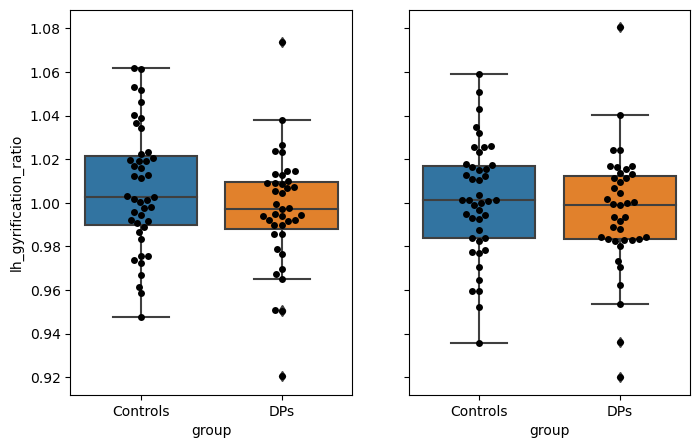

In [9]:
## violin plot of gyrification ratios between groups

fig, ax = plt.subplots(figsize = (8, 5), nrows = 1, ncols = 2, sharey=True)
sns.swarmplot(x = 'group', y = 'lh_gyrification_ratio', data = gyr_ratio, ax=ax[0], color='black')
sns.boxplot(x = 'group', y = 'lh_gyrification_ratio', data = gyr_ratio, ax=ax[0])
sns.swarmplot(x = 'group', y = 'rh_gyrification_ratio', data = gyr_ratio, ax=ax[1], color='black')
sns.boxplot(x = 'group', y = 'rh_gyrification_ratio', data = gyr_ratio, ax=ax[1])


## Gyrification by lobe

Note: to get the lobe labels used below, I used the --lobesStrict flag on annotation2label - which creates labels for frontal, occipital, temporal, partietal, cingulate, and insula

Alternatively you can decompose the DK atlas and use the following label assignments:



In [10]:
lobes_dict = {'Frontal' : ['precentral', 'caudalmiddlefrontal', 'parsopercularis', 'parstriangularis', 'parsorbitalis', 
              'rostralmiddlefrontal', 'superiorfrontal', 'lateralorbitofrontal', 'medialorbitofrontal',
              'rostralanteriorcingulate','caudalanteriorcingulate'],

              'Parietal' : ['posteriorcingulate', 'paracentral', 'isthmuscingulate' ,'precuneus', 'postcentral', 
              'superiorparietal', 'supramarginal','inferiorparietal', 'superiorparietal'],
              
              'Occipital': ['cuneus', 'pericalcarine', 'lingual', 'lateraloccipital'],
              
              'Temporal' : ['fusiform', 'parahippocampal', 'entorhinal', 'inferiortemporal', 'middletemporal', 
              'superiortemporal', 'transversetemporal'],
              
              'Insula' : ['insula']}

In [11]:
## Reqrite the annotation results from --lobesStrict to individual labels

# from src.freesurfer_utils import freesurfer_annotation2label
# subjects_dir = '/Users/benparker/Desktop/cnl/neurocluster/weiner/DevProso/subjects'
# for sub in subjects:
#     outdir = f"{subjects_dir}/{sub}/label"
#     freesurfer_annotation2label(subjects_dir, sub, outdir=outdir, annot_name='lobes')

Load curvature files and write each lobe's sulci and gyri as a separate label

In [12]:
import src.freesurfer_utils as fsu

lobes = ['temporal', 'occipital', 'parietal', 'frontal', 'cingulate', 'insula']

for sub in subjects:
    for lobe in lobes:
        for hemi in ['lh', 'rh']:
            subject_curv = nib.freesurfer.io.read_morph_data(f"{subjects_dir}/{sub}/surf/{hemi}.curv")
            lobe_label = f"{subjects_dir}/{sub}/label/{hemi}.{lobe}.label"
            print(lobe_label)
            lobe_ind, lobe_vert = fsu.read_label(lobe_label)
            lobe_sulcus_ind, lobe_sulcus_vert = fsu.get_sulcus(lobe_ind, lobe_vert, subject_curv)
            
            fsu.write_label(lobe_sulcus_ind, lobe_sulcus_vert, f'{lobe}_sulcus', hemi, f"{subjects_dir}/{sub}", overwrite=True)

            lobe_gyrus_ind, lobe_gyrus_vert = fsu.get_gyrus(lobe_ind, lobe_vert, subject_curv)
            print(lobe_sulcus_ind, lobe_sulcus_vert)
            fsu.write_label(lobe_gyrus_ind, lobe_gyrus_vert, f'{lobe}_gyrus', hemi, f"{subjects_dir}/{sub}", overwrite=True)


/Users/benparker/Desktop/cnl/neurocluster/weiner/DevProso/subjects/1/label/lh.temporal.label
Writing label lh.temporal_sulcus.label for 1
[ 18680  18681  18682 ... 144108 144109 144111] [[-25.605 -61.024 -16.834]
 [-26.091 -61.189 -16.817]
 [-26.796 -61.193 -17.003]
 ...
 [-31.837  24.84  -15.98 ]
 [-31.415  24.73  -16.204]
 [-30.75   25.106 -16.112]]
Writing label lh.temporal_gyrus.label for 1
/Users/benparker/Desktop/cnl/neurocluster/weiner/DevProso/subjects/1/label/rh.temporal.label
Writing label rh.temporal_sulcus.label for 1
[ 14297  14298  14308 ... 119670 119674 119700] [[ 11.618 -61.5   -11.842]
 [ 10.845 -61.407 -11.665]
 [ 12.031 -61.668 -12.577]
 ...
 [ 28.711  36.917 -25.251]
 [ 30.122  37.046 -26.81 ]
 [ 28.784  36.397 -30.047]]
Writing label rh.temporal_gyrus.label for 1
/Users/benparker/Desktop/cnl/neurocluster/weiner/DevProso/subjects/1/label/lh.occipital.label
Writing label lh.occipital_sulcus.label for 1
[   150    236    249 ...  63142  63143 143916] [[ -9.266 -87.97

run mris_anatomical_stats on the new sulcus and gyrus labels - shell script located at /home/weiner/bparker/code/shell/mri_anatomical_stats.sh